# Random Forest Classifier

In this notebook, we implement random forest classifier to understand the algorithm. 

The implementation here is based on the description in the book "Hands-On Machine Learning with Scikit-Learn & TensorFlow" by Aurelien Geron ( http://shop.oreilly.com/product/0636920052289.do ).

In [16]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# to make this notebook's output stable across runs
np.random.seed(42)

# 1 Setting 

Here we consider classification problems. 

* Let $N \in \mathbb{N}$ be the number of training data points, 
* $d \in \mathbb{N}$ be the dimension of input, 
* $\mathcal{C} = \left\{ 0, 1, \dots, C-1 \right\}$ be the set of class labels, 
* $x_0, x_1, \dots , x_{N-1} \in \mathbb{R}^d$ be the training input data, $y_0, y_1, \dots, y_{N-1} \in \mathcal{C}$ be the training labels, 
$y := {}^t (y_0, \dots, y_{N-1}) \in \mathcal{C}^N$.

# 2 The idea behind random forest

The random forest is an ensemble method, where 
* We train multiple decision trees on different bootstrap training data randomly sampled from the original training data (Thus, we have the name random forest. ). Typically, the sample size is set to be the same as the original training data size, and the sampling is performed with replacement (i.e., we perform bagging).
* In training each decision tree, in each splitting process, only some features (which are randomly sampled) are used to determine the splitting. 
* In making prediction, we let all the trees to make their own predictions, and employ the most frequently predicted class.

# 3 From math to Code

Here, for understanding the idea of random forest, we use `DecisionTreeClassifier` implemented in scikit-learn, and construct a random forest classifier by ourselves. For the detail of `DecisoinTreeClassifier` class, please see http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html 

Note that the `DecisionTreeClassifier` class implements splitting based on randomly sampled features, and what we have to do here is just to implement the bagging process.

First, we define a function which returns randomly sampled indices of the original training data.

In [17]:
def generate_random_indices(n_samples, n_data):
    return np.random.randint(low=0, high=n_data, size=n_samples)

Using the indices generated by this function, we perform bootstrap sampling from the original training data. 

Although we can implement the process directly, it would produce a new array with the same size as the training data for each tree, resulting  in higher memory usage. 
Instead, we can use `sample_weight` parameter for each decision tree to efficiently implement the sampling process, where we set the `sample_weight` as the frequency in the indices generate by `random_indices`.

In [18]:
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import mode

class RFC:
    def __init__(self, n_estimators=10, max_features='auto', criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.n_estimators = n_estimators # the number of decision trees in the random forest
        self.max_features = max_features
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        
    def fit(self, X, y):
        """
        This method performs fitting. 
        
        Parameters
        ----------
        X : 2-D numpy array
            If np.shape(X) = (n,m), then n is understood to be the number of trainin data, and m is understood to be the dimension of each input data point
        y : 1-D numpy array
            A 1-D array containing labels of training data, where labels should be of int type.
        """
        
        n_data = np.shape(X)[0]
        self.trees = [DecisionTreeClassifier(criterion=self.criterion, 
                                        max_depth=self.max_depth, 
                                        min_samples_split=self.min_samples_split, 
                                        min_samples_leaf=self.min_samples_leaf, 
                                        max_features=self.max_features) for i in range(self.n_estimators)]
        
        for tree in self.trees:
            indices = generate_random_indices(n_data, n_data)
            sample_count = np.bincount(indices, minlength=n_data)
            tree.fit(X, y, sample_weight=sample_count)
            
    def predict(self, X):
        """
        This method performs prediction, and returns the result. 
        
        Parameters
        ----------
        X : 2-D numpy array
            If np.shape(X) = (n,m), then n is understood to be the number of trainin data, and m is understood to be the dimension of each input data point
        
        Returns
        ----------
        predicted_label : 1-D numpy array
            An array containing predicted labels
        """
        predictions = np.zeros((self.n_estimators, len(X)))
        for (cnt, tree) in enumerate(self.trees):
            predictions[cnt] = tree.predict(X)
        predicted_label = mode(predictions, axis=0)[0][0]
        return predicted_label

# 4 Experiment

In this section, we apply our random forest classifier to some dataset, and see how the behavior of the classifier changes with the change of hyperparameters.

In [19]:
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## 4.1 Moon dataset

First, we use moon dataset, which can be easily visualized due to its low dimension.

In [20]:
N = 100
X, y = datasets.make_moons(n_samples = N, noise = 0.2)

xx1 = np.linspace(np.min(X[:,0]),np.max(X[:,0]),101)
xx2 = np.linspace(np.min(X[:,1]),np.max(X[:,1]),100)
Xtest = np.array([[x1,x2] for x1 in xx1  for x2 in xx2])
xxx1, xxx2 = np.meshgrid(xx1, xx2)

def plot_result(clf):
    plt.plot(X[:,0][y==1], X[:,1][y==1],"o",label="1")
    plt.plot(X[:,0][y==0], X[:,1][y==0],"o",label="0")
    plt.legend()
    pred_val = clf.predict(Xtest)
    pred_val_2D = np.reshape(pred_val,(len(xx1),len(xx2))).T
    plt.pcolormesh(xxx1, xxx2, pred_val_2D)
    plt.colorbar()
    plt.show()

First, let us check the result for decision tree classifier.

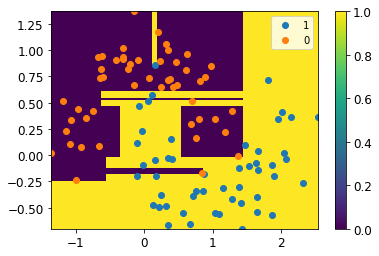

In [21]:
clf = DecisionTreeClassifier(max_features='auto')
clf.fit(X, y)
plot_result(clf)

Apparently, the deicision boundary is complicated, and the classifier overfits the training data. 
Let us see how the situation changes as we use random forest and increase the number of estimators.

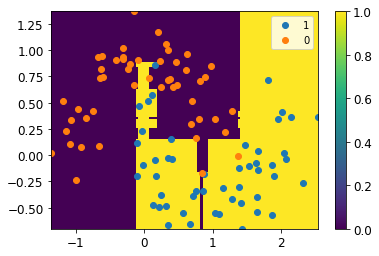

In [22]:
clf = RFC(n_estimators=3)
clf.fit(X, y)
plot_result(clf)

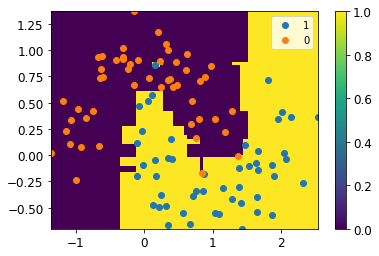

In [23]:
clf = RFC(n_estimators=5)
clf.fit(X, y)
plot_result(clf)

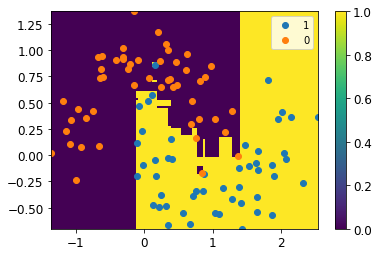

In [24]:
clf = RFC(n_estimators=10)
clf.fit(X, y)
plot_result(clf)

Roughly speaking, the deicsion boundary gets smoother as we increase `n_estimators`.

## 4.2 MNIST hand written digit

Here we shall try out an experiments on MNIST hand written digit dataset.

In [25]:
digits = datasets.load_digits()
dat_train, dat_test, label_train, label_test = train_test_split(digits.data, digits.target, test_size=0.25)
print(f"Training data : {len(dat_train)}")
print(f"Test data : {len(dat_test)}")

Training data : 1347
Test data : 450


In [26]:
def show_result_digit(clf):
    label_test_pred = clf.predict(dat_test)
    print(f"train accuracy score: {accuracy_score(label_train, clf.predict(dat_train))}")
    print(f"test accuracy score: {accuracy_score(label_test, label_test_pred)}")

In [27]:
clf = DecisionTreeClassifier()
clf.fit(dat_train, label_train)
show_result_digit(clf)

train accuracy score: 1.0
test accuracy score: 0.8222222222222222


In [28]:
clf = RFC(n_estimators=3)
clf.fit(dat_train, label_train)
show_result_digit(clf)

train accuracy score: 0.9695619896065331
test accuracy score: 0.8466666666666667


In [29]:
clf = RFC(n_estimators=10)
clf.fit(dat_train, label_train)
show_result_digit(clf)

train accuracy score: 0.9992576095025983
test accuracy score: 0.94


In [30]:
clf = RFC(n_estimators=100)
clf.fit(dat_train, label_train)
show_result_digit(clf)

train accuracy score: 1.0
test accuracy score: 0.9777777777777777


Being consistent with our insight from the moon dataset case, the generalization error seems to improve as we increase the number of decision trees contained in the forest (Although I am not sure whether this trend continues as we increase `n_estimators` infinitely.).